In [1]:
import torch
from jaxtyping import Int, Float
from typing import Tuple
from torch import Tensor
from timm.layers.helpers import to_2tuple
from torch import nn
from PIL import Image
import numpy as np
from torchvision.transforms.v2.functional import to_image, to_dtype, to_dtype_image


In [2]:
PATCH_SIZE = 16
IMG_SIZE = 224
MASK_RATIO = 0.5
img = Image.open("../../artifacts/img.jpg").resize((224, 224)).convert("RGB")
img = to_dtype_image(to_image(img), dtype=torch.float32, scale=True).unsqueeze(0)


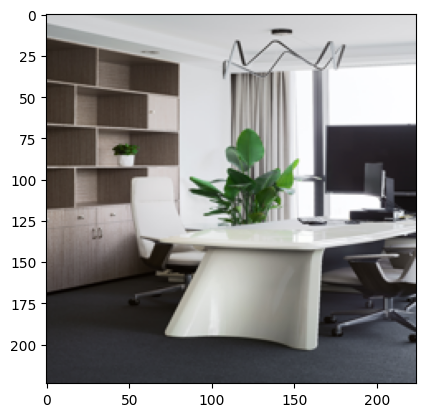

In [3]:
# plot image
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0))

In [4]:
import torch
import math
from torch import Tensor

def stratified_jittered_sampling(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> tuple[Tensor, Tensor]:
    """
    Generate stratified jittered patch positions in a vectorized manner.
    
    Args:
        B: Batch size.
        H, W: Image height and width.
        patch_size: Size of each patch.
        N_vis: Number of visible patches to sample.
        device: Torch device.
        
    Returns:
        ys, xs: Tensors of shape [B, N_vis] with integer top-left coordinates.
    """
    valid_H = H - patch_size  # maximum valid y coordinate
    valid_W = W - patch_size  # maximum valid x coordinate

    # Determine grid dimensions for stratification.
    # We choose grid_rows such that grid_rows = floor(sqrt(N_vis)),
    # and grid_cols = ceil(N_vis / grid_rows) so that grid_rows * grid_cols >= N_vis.
    grid_rows = int(math.floor(math.sqrt(N_vis)))
    grid_cols = int(math.ceil(N_vis / grid_rows))
    cell_h = valid_H / grid_rows
    cell_w = valid_W / grid_cols

    # Create a meshgrid of cell indices.
    row_idx = torch.arange(grid_rows, device=device).float().unsqueeze(1)  # shape [grid_rows, 1]
    col_idx = torch.arange(grid_cols, device=device).float().unsqueeze(0)   # shape [1, grid_cols]
    
    # Generate random jitter for each cell.
    rand_y = torch.rand((grid_rows, grid_cols), device=device)
    rand_x = torch.rand((grid_rows, grid_cols), device=device)
    
    # Compute jittered coordinates within each cell.
    ys_grid = (row_idx + rand_y) * cell_h  # shape [grid_rows, grid_cols]
    xs_grid = (col_idx + rand_x) * cell_w  # shape [grid_rows, grid_cols]
    
    # Clamp coordinates to the valid range.
    ys_grid = torch.clamp(ys_grid, max=valid_H)
    xs_grid = torch.clamp(xs_grid, max=valid_W)
    
    # Flatten the grid.
    ys_flat = ys_grid.flatten()  # shape [grid_rows * grid_cols]
    xs_flat = xs_grid.flatten()  # shape [grid_rows * grid_cols]
    total_candidates = ys_flat.shape[0]  # equals grid_rows * grid_cols, which is >= N_vis

    # Always select N_vis indices without needing a conditional.
    perm = torch.randperm(total_candidates, device=device)[:N_vis]
    ys_sampled = ys_flat[perm].long()
    xs_sampled = xs_flat[perm].long()
    
    # Expand to batch size.
    ys_sampled = ys_sampled.unsqueeze(0).expand(B, -1)
    xs_sampled = xs_sampled.unsqueeze(0).expand(B, -1)
    return ys_sampled, xs_sampled

def stratified_jittered_sampling_per_batch(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> tuple[Tensor, Tensor]:
    """
    Generate stratified jittered patch positions independently for each batch item.
    
    For each batch item, we:
      1. Divide the valid region ([0, H - patch_size] x [0, W - patch_size]) into a grid.
      2. Add random jitter to the grid cell centers.
      3. Flatten the candidate grid to get a list of candidate coordinates.
      4. For each batch item, select N_vis indices from its candidate grid.
    
    This yields a tensor of y coordinates and a tensor of x coordinates of shape [B, N_vis]
    with different values for each batch item.
    """
    valid_H = H - patch_size  # maximum valid top-left y
    valid_W = W - patch_size  # maximum valid top-left x

    # Determine grid dimensions such that grid_rows * grid_cols >= N_vis.
    grid_rows = int(math.floor(math.sqrt(N_vis)))
    grid_cols = int(math.ceil(N_vis / grid_rows))
    cell_h = valid_H / grid_rows
    cell_w = valid_W / grid_cols

    # Create a candidate grid per batch.
    # row_idx: shape [B, grid_rows, grid_cols]
    row_idx = torch.arange(grid_rows, device=device).float().unsqueeze(0).unsqueeze(2).expand(B, -1, grid_cols)
    # col_idx: shape [B, grid_rows, grid_cols]
    col_idx = torch.arange(grid_cols, device=device).float().unsqueeze(0).unsqueeze(1).expand(B, grid_rows, -1)
    
    # Generate random jitter for each batch independently.
    rand_y = torch.rand(B, grid_rows, grid_cols, device=device)
    rand_x = torch.rand(B, grid_rows, grid_cols, device=device)
    
    # Compute jittered candidate coordinates.
    ys_grid = (row_idx + rand_y) * cell_h
    xs_grid = (col_idx + rand_x) * cell_w
    
    # Clamp to valid range.
    ys_grid = torch.clamp(ys_grid, max=valid_H)
    xs_grid = torch.clamp(xs_grid, max=valid_W)
    
    # Flatten candidate grid per batch: shape [B, total_candidates]
    ys_flat = ys_grid.reshape(B, -1)
    xs_flat = xs_grid.reshape(B, -1)
    total_candidates = ys_flat.size(1)  # equals grid_rows * grid_cols
    
    # For each batch element, randomly select N_vis candidate indices.
    # Generate random scores per batch and sort.
    random_scores = torch.rand(B, total_candidates, device=device)
    sorted_indices = random_scores.argsort(dim=1)
    # Select the first N_vis indices for each batch.
    sel_indices = sorted_indices[:, :N_vis]
    
    # Gather the coordinates for each batch element.
    ys_sampled = torch.gather(ys_flat, 1, sel_indices).long()
    xs_sampled = torch.gather(xs_flat, 1, sel_indices).long()
    return ys_sampled, xs_sampled

def random_sampling(
    B: int, H: int, W: int, patch_size: int, N_vis: int, device: torch.device
) -> tuple[Int[Tensor, "B N"], Int[Tensor, "B N"]]:
    xs = torch.randint(0, W - patch_size, (B, N_vis), device=device)
    ys = torch.randint(0, H - patch_size, (B, N_vis), device=device)
    return ys, xs


def ongrid_sampling(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate on-grid patch positions independently for each batch element.
    
    The function computes a full grid of top-left coordinates for patches,
    then for each batch element, it generates random scores for each candidate and
    selects the top N_vis indices. This yields tensors of shape [B, N_vis] with
    different coordinates for each batch element.
    
    Args:
        B: Batch size.
        H, W: Image dimensions.
        patch_size: Patch size (assumed square).
        N_vis: Number of visible patches to sample.
        device: Torch device.
        
    Returns:
        ys, xs: Tensors of shape [B, N_vis] with integer coordinates.
    """
    # Create full grid of valid top-left coordinates.
    grid_y = torch.arange(0, H - patch_size + 1, patch_size, device=device)
    grid_x = torch.arange(0, W - patch_size + 1, patch_size, device=device)
    grid_y, grid_x = torch.meshgrid(grid_y, grid_x, indexing="ij")
    grid_y = grid_y.flatten()  # [total_patches]
    grid_x = grid_x.flatten()  # [total_patches]
    total_patches = grid_y.numel()
    
    # Ensure N_vis does not exceed the total number of patches.
    N_vis = min(N_vis, total_patches)
    
    # For each batch element, generate random scores for all candidates.
    random_scores = torch.rand(B, total_patches, device=device)
    # Sort to get indices, then select top N_vis candidates.
    _, perm = random_scores.sort(dim=1)
    perm = perm[:, :N_vis]  # shape: [B, N_vis]
    
    # Gather candidate coordinates for each batch element.
    ys_sampled = torch.gather(grid_y.unsqueeze(0).expand(B, -1), 1, perm)
    xs_sampled = torch.gather(grid_x.unsqueeze(0).expand(B, -1), 1, perm)
    
    return ys_sampled, xs_sampled

In [5]:
class OffGridPatcher(nn.Module):
    """
    Variant: Gather flattened patches and use a linear projection.
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        sampler: callable = random_sampling,
        mask_ratio: float = 0.0,
    ) -> None:
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.patch_embed = LinearPatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_chans,
            embed_dim=embed_dim,
        )
        self.sampler = sampler
        self.mask_ratio = mask_ratio


    def _create_sampled_grid_flattened(
        self,
        patch_size: int,
        H: int,
        W: int,
        ys: Int[Tensor, "B N"],
        xs: Int[Tensor, "B N"],
    ) -> Int[Tensor, "B (N*P*P)"]:
        B, n_patches = ys.size(0), ys.size(1)
        dy = torch.arange(patch_size, device=ys.device).unsqueeze(1)
        dx = torch.arange(patch_size, device=ys.device).unsqueeze(0)
        d = (dy * W + dx).view(-1)
        base = ys * W + xs
        indices = base.unsqueeze(-1) + d.unsqueeze(0)
        return indices.view(B, n_patches * patch_size * patch_size)

    def forward(
        self, x: Float[Tensor, "B C H W"]
    ) -> tuple[Float[Tensor, "B N D"], Int[Tensor, "B N 2"]]:
        B, C, H, W = x.shape
        N = (H // self.patch_size) * (W // self.patch_size)
        N_vis = int(N * (1 - self.mask_ratio))
        ys, xs = self.sampler(B, H, W, self.patch_size, N_vis, x.device)
        patch_positions = torch.stack([ys, xs], dim=-1)
        patch_area = self.patch_size * self.patch_size
        indices = self._create_sampled_grid_flattened(self.patch_size, H, W, ys, xs)
        indices = indices.unsqueeze(1).expand(B, C, -1)
        patches_flat = x.flatten(-2).gather(2, indices)
        patches_flat = patches_flat.view(B, C, N_vis, patch_area)
        patches_flat = patches_flat.permute(0, 2, 1, 3).reshape(
            B, N_vis, C * patch_area
        )
        # patch_tokens = self.patch_embed(patches_flat)
        return patches_flat, patch_positions

    

class LinearPatchEmbed(nn.Module):
    """
    Linear patch embedding using nn.Unfold.
    Expects input patches of shape [B, num_patches, C*patch_size*patch_size].
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
    ) -> None:
        super().__init__()
        self.patch_size: int = patch_size
        self.embed_dim: int = embed_dim
        self.num_patches: int = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x: Float[Tensor, "B N (C P P)"]) -> Float[Tensor, "B N D"]:
        return self.proj(x)
    

class LinearPatchEmbedWithUnfold(nn.Module):
    """
    Linear patch embedding using nn.Unfold.
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
    ) -> None:
        super().__init__()
        self.patch_size: int = patch_size
        self.embed_dim: int = embed_dim
        self.num_patches: int = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x: Float[Tensor, "B C H W"]) -> Float[Tensor, "B N D"]:
        B, C, H, W = x.shape
        x_unf = nn.functional.unfold(x, self.patch_size, stride=self.patch_size)
        x_unf = x_unf.transpose(1, 2).reshape(B, C * self.patch_size * self.patch_size, -1)
        return self.proj(x_unf)
    


In [6]:
def ongrid_sampling_canonical(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate on-grid patch positions independently for each batch element,
    then return the selected (visible) patches in canonical order.
    
    The function computes the full grid of top-left coordinates for patches,
    generates random scores per candidate, selects N_vis indices per batch,
    then sorts those indices in ascending (canonical) order.
    
    Args:
        B: Batch size.
        H, W: Image dimensions.
        patch_size: Patch size (assumed square).
        N_vis: Number of visible patches to sample.
        device: Torch device.
    
    Returns:
        ys, xs: Tensors of shape [B, N_vis] with integer coordinates in canonical order.
    """
    # Create full grid of valid top-left coordinates.
    grid_y = torch.arange(0, H - patch_size + 1, patch_size, device=device)
    grid_x = torch.arange(0, W - patch_size + 1, patch_size, device=device)
    grid_y, grid_x = torch.meshgrid(grid_y, grid_x, indexing="ij")
    grid_y = grid_y.flatten()  # [total_patches]
    grid_x = grid_x.flatten()  # [total_patches]
    total_patches = grid_y.numel()

    # Ensure N_vis does not exceed the total number of patches.
    N_vis = min(N_vis, total_patches)

    # For each batch element, generate random scores for all candidate positions.
    random_scores = torch.rand(B, total_patches, device=device)
    # Sort the random scores to get a random permutation of the candidate indices.
    _, perm = random_scores.sort(dim=1)
    perm = perm[:, :N_vis]  # shape: [B, N_vis]

    # Now sort the selected indices so that they appear in canonical order.
    perm, _ = perm.sort(dim=1)

    # Gather the candidate coordinates using the sorted indices.
    ys_sampled = torch.gather(grid_y.unsqueeze(0).expand(B, -1), 1, perm)
    xs_sampled = torch.gather(grid_x.unsqueeze(0).expand(B, -1), 1, perm)

    return ys_sampled, xs_sampled

# Example usage:
if __name__ == "__main__":
    B, H, W, patch_size, N_vis = 3, 224, 224, 16, 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ys, xs = ongrid_sampling_canonical(B, H, W, patch_size, N_vis, device)
    for b in range(B):
        print(f"Batch {b} positions:", torch.stack([ys[b], xs[b]], dim=-1))


Batch 0 positions: tensor([[ 80,   0],
        [ 80, 144],
        [ 96,  48],
        [112,  16],
        [128,   0],
        [128,  48],
        [144,   0],
        [144,  64],
        [160, 176],
        [176,  96]], device='cuda:0')
Batch 1 positions: tensor([[ 32, 144],
        [ 32, 176],
        [ 64,  48],
        [ 64, 128],
        [ 64, 192],
        [ 80, 160],
        [ 96,  16],
        [112,   0],
        [128, 112],
        [128, 208]], device='cuda:0')
Batch 2 positions: tensor([[ 16, 160],
        [ 48,  16],
        [ 48,  48],
        [ 48,  80],
        [ 64, 128],
        [112,  80],
        [128,   0],
        [160,  32],
        [176, 192],
        [208,  48]], device='cuda:0')


/tmp/ipykernel_6807/1469136567.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


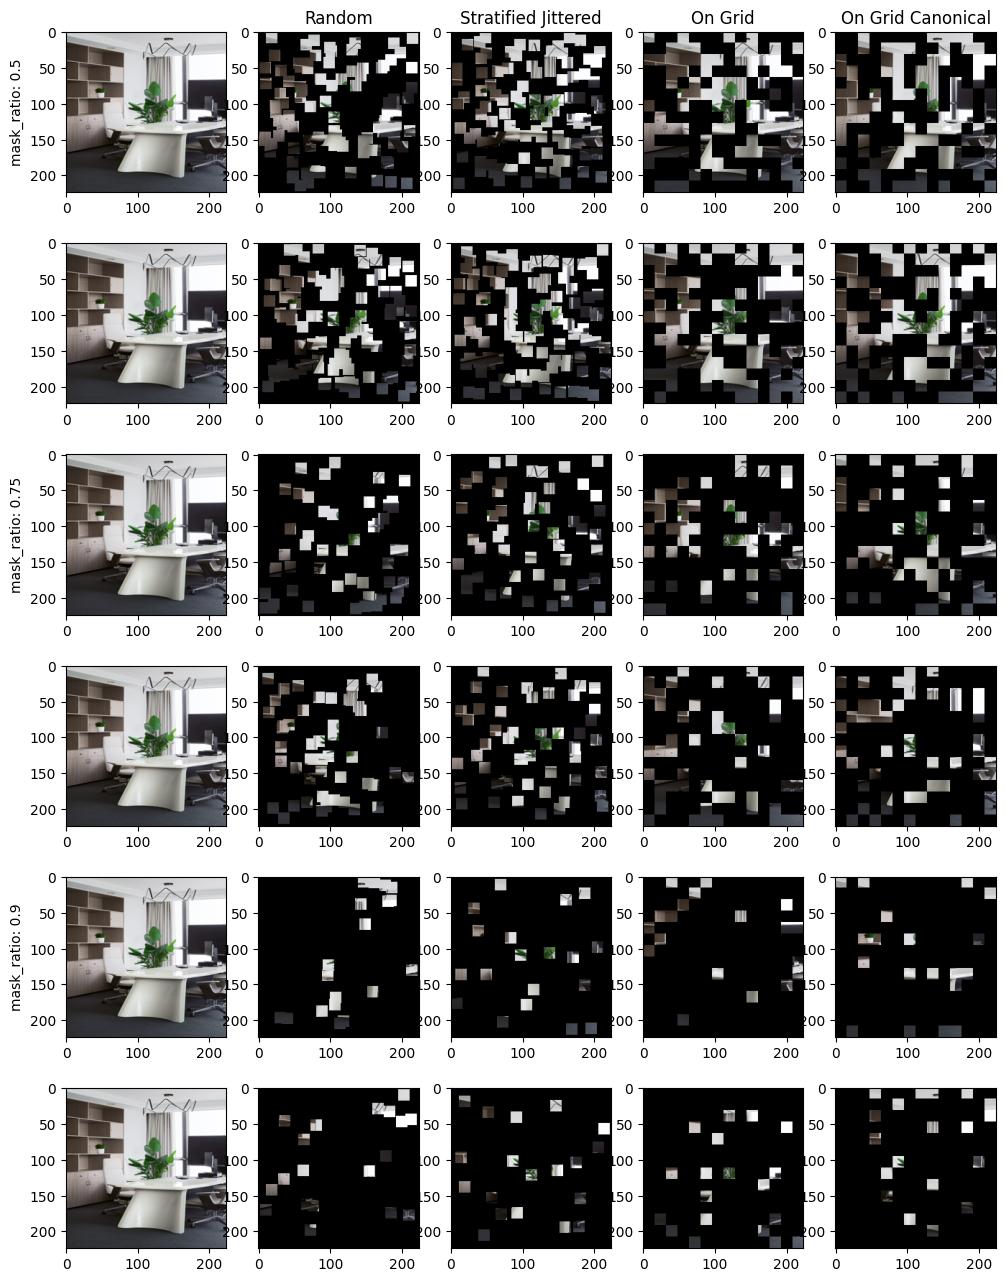

In [9]:
import torch
import torch
import matplotlib.pyplot as plt

def reconstruct_image_from_patches(
    patches: torch.Tensor,
    patch_positions: torch.Tensor,
    img_shape: tuple[int, int, int, int],
    patch_size: int,
) -> torch.Tensor:
    """
    Reconstruct an image from off-grid patches.
    
    Args:
        patches: Tensor of shape [B, N, C*patch_size*patch_size] (flattened patches).
        patch_positions: Tensor of shape [B, N, 2] giving (y, x) top-left coordinates.
        img_shape: The desired output image shape, e.g. (B, C, H, W).
        patch_size: The size of each patch (assumed square).
        
    Returns:
        A tensor of shape [B, C, H, W] with the patches pasted at the given positions.
    """
    B, C, H, W = img_shape
    reconstructed = torch.zeros(img_shape, device=patches.device, dtype=patches.dtype)
    N = patches.shape[1]
    # Reshape patches to [B, N, C, patch_size, patch_size]
    patches = patches.view(B, N, C, patch_size, patch_size)
    for b in range(B):
        for i in range(N):
            y, x = patch_positions[b, i]  # top-left coordinates
            # Paste patch into reconstructed image at (y, x)
            reconstructed[b, :, y:y+patch_size, x:x+patch_size] = patches[b, i]
    return reconstructed

# Sample image and patch extraction parameters.
P, img_size, C = 16, 224, 3
H, W = img_size, img_size
B = 2

samplers = {
    "Random": random_sampling,
    "Stratified Jittered": stratified_jittered_sampling_per_batch,
    "On Grid": ongrid_sampling,
    "On Grid Canonical": ongrid_sampling_canonical,
}

mask_ratios = [0.5, 0.75, 0.9]
fig, axes = plt.subplots(len(mask_ratios) * B, 1 + len(samplers), figsize=(12, 16))
axes = axes.reshape(len(mask_ratios), B, 1 + len(samplers))

# add row titles
for ax, mask_ratio in zip(axes[:, 0, 0], [0.5, 0.75, 0.9]):
    ax.set_ylabel(f"mask_ratio: {mask_ratio}")
# column titles
for ax, sampler_name in zip(axes[0, 0, 1:], samplers.keys()):
    ax.set_title(sampler_name)

img_batch = torch.cat([img] * 2, dim=0)

# ROWS: mask_ratio: 0.5, 0.75, 0.9
for ax, mask_ratio in zip(axes, [0.5, 0.75, 0.9]):
    # COLS: 0: original, 1: random_sampling, 2: stratified_jittered_sampling
    ax[0][0].imshow(img_batch[0].permute(1, 2, 0).detach().cpu().numpy())
    ax[1][0].imshow(img_batch[1].permute(1, 2, 0).detach().cpu().numpy())

    for ix, (sampler_name, sampler) in enumerate(samplers.items()):
        patcher = OffGridPatcher(patch_size=P, mask_ratio=mask_ratio, sampler=sampler)
        patches, patch_positions = patcher(img_batch)
        reconstructed_img = reconstruct_image_from_patches(patches, patch_positions, (B, C, H, W), patch_size=P)
        ax[0][ix + 1].imshow(reconstructed_img[0].permute(1, 2, 0).detach().cpu().numpy())
        ax[1][ix + 1].imshow(reconstructed_img[1].permute(1, 2, 0).detach().cpu().numpy())

fig.show()

In [ ]:
grid_size = 14
grid_h = np.arange(grid_size, dtype=np.float32)
grid_w = np.arange(grid_size, dtype=np.float32)
grid = np.meshgrid(grid_w, grid_h)  # here w goes first
grid = np.stack(grid, axis=0)

In [ ]:
from src.models.components.utils.offgrid_pos_embed import get_2d_sincos_pos_embed, get_canonical_coords, get_canonical_pos_embed
from src.models.components.utils.pos_embed import get_2d_sincos_pos_embed as get_2d_sincos_pos_embed_droppos

embed_dim = 16
grid_size = 14
patch_size = 16
coords = get_canonical_coords((grid_size, grid_size), patch_size)
m = get_2d_sincos_pos_embed(coords/patch_size, embed_dim)
# m = get_canonical_pos_embed(embed_dim, (grid_size, grid_size), patch_size).squeeze()
d = get_2d_sincos_pos_embed_droppos(embed_dim, grid_size)
d = torch.from_numpy(d).float()


torch.allclose(m, d, atol=1e-5)


True

In [6]:
def load_part():
    from functools import partial
    from src.models.part_vit_module_v3 import PARTModule
    from src.models.components.partmae import PARTMaskedAutoEncoderViT as PARTMaskedAutoEncoderViTV1

    path = "../../artifacts/model-2knf0d16:v0/epoch=108-step=68234.ckpt"  #@param {type:"string"}
    # reassign src.models.components.part_utils to src.models.components.utils.part_utils
    import sys
    sys.modules['src.models.components.partv3'] = sys.modules['src.models.components.partmae']
    back = PARTModule.load_from_checkpoint(path, strict=False)
    return back.eval()

In [7]:
partmae_ongrid = load_part().net.cpu()

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [8]:
from src.models.components.partmae_v2 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b

# load ongrid checkpoint to the model
state_dict = partmae_ongrid.state_dict()
partmae_offgrid = PART_mae_vit_base_patch16_dec512d8b(mask_ratio=0.0, sampler="ongrid").eval()

# reshape partmae_ongrid.patch_embed.weight.proj (conv2d) to partmae_offgrid.patch_embed.proj (linear)

state_dict["patch_embed.proj.weight"] = state_dict["patch_embed.proj.weight"].reshape(768, -1)

partmae_offgrid.load_state_dict(state_dict, strict=True)


<All keys matched successfully>

In [9]:
img_batch = torch.cat([img] * 2, dim=0)

In [10]:
with torch.no_grad():
    out_offgrid = partmae_offgrid(img_batch)
print(list(out_offgrid.keys()))


['z', 'patch_positions_vis', 'patch_positions_pos', 'ids_remove_pos', 'mask_pos', 'ids_keep_pos', 'ids_restore_pos', 'pred_T', 'loss', 'patch_pair_indices', 'gt_T']


In [11]:
with torch.no_grad():
    out_ongrid = partmae_ongrid(img)
print(list(out_ongrid.keys()))


['z', 'mask', 'ids_keep', 'ids_restore', 'mask_pos', 'ids_keep_pos', 'ids_restore_pos', 'pred_T', 'ids_nopos', 'x_shuffled', 'patch_positions', 'loss', 'patch_pair_indices', 'gt_T']


In [12]:
def _get_refpatch_id_batch(
    patch_positions_vis: Int[Tensor, "B N_vis 2"],
    img_size: tuple[int, int],
    ids_remove_pos: Int[Tensor, "B N_nopos"],
) -> Int[Tensor, "B"]:
    # only works for offgrid patchmae
    
    # Create ideal refpatch positions for all batches at once
    center_refpatch_yx = torch.tensor(img_size, device=patch_positions_vis.device) // 2

    patch_positions_nopos = torch.gather(
        patch_positions_vis, dim=1, index=ids_remove_pos.unsqueeze(-1).repeat(1, 1, 2)
    )

    # Compute L1 distances in batched manner
    distances = (patch_positions_nopos - center_refpatch_yx.view(1, 1, 2)).abs().sum(2)

    # Get closest patch index for each batch
    idx = torch.argmin(distances, dim=1)

    # idx is w.r.t to the ids_remove_pos, need to convert to the original ids
    refpatch_ids = torch.gather(ids_remove_pos, dim=1, index=idx.unsqueeze(-1))
    return refpatch_ids

In [13]:
out= out_offgrid

In [14]:
print(out["ids_remove_pos"][0, 0])
print(out["patch_positions_vis"][0, 0])
print(out["patch_positions_vis"][0, 29])

tensor(0)
tensor([64,  0])
tensor([112,  16])


In [18]:
rids = _get_refpatch_id_batch(out["patch_positions_vis"], (224, 224), out["ids_remove_pos"])
rids.squeeze(-1)

tensor([124,  84])

In [33]:
def create_image_from_transforms(
    ref_transforms: dict[int, Tensor],
    patch_positions: Int[Tensor, "n_patches 2"],
    patch_size: int,
    img: Float[Tensor, "3 H W"],
    refpatch_id: int,
):
    new_img = torch.zeros_like(img)
    _, H, W = img.shape
    for node, t in ref_transforms.items():
        y, x = patch_positions[node]
        t_rounded = t.round().to(torch.int64)
        new_y, new_x = patch_positions[refpatch_id] + t_rounded
        # TODO: relax this constraint:
        # Instead of rejecting the entire patch if there's at least a pixel outside the image,
        # we can just paint the part of the patch that is inside the image.
        if 0 <= new_y <= H - patch_size and 0 <= new_x <= W - patch_size:
            new_img[:, new_y : new_y + patch_size, new_x : new_x + patch_size] = img[
                :, y : y + patch_size, x : x + patch_size
            ]
    return new_img


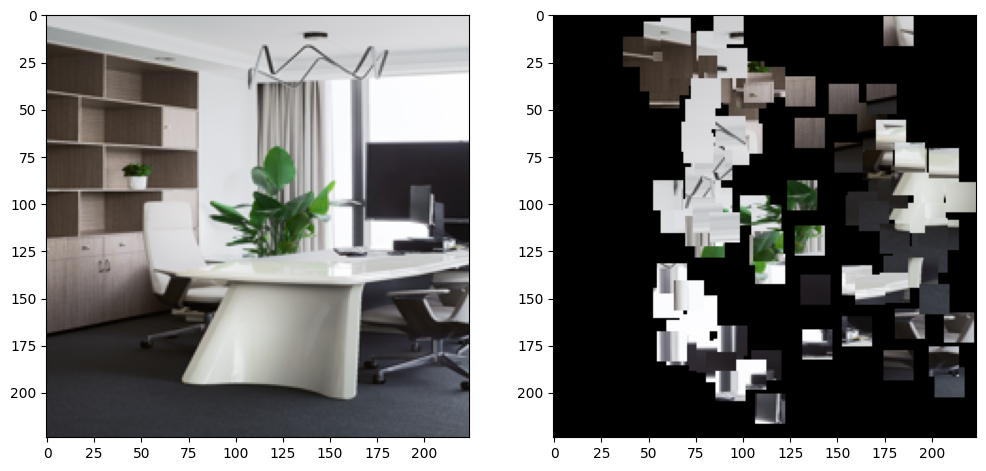

In [34]:
from src.utils.visualization.reconstruction import (
    plot_reconstructions,
)
from src.utils.visualization.visualization import (
    get_transforms_from_reference_patch_batch,
)

img_size: tuple[int, int] = img.shape[-2:]
refpatch_id = _get_refpatch_id_batch(
    out["patch_positions_vis"], img_size, out["ids_remove_pos"]
)
refpatch_id = refpatch_id.tolist()

# patch_pair_indices : idx_remove_pos x ids_remove_pos, where x is cross 

ref_transforms = get_transforms_from_reference_patch_batch(
    refpatch_id[0], out["pred_T"], out["patch_pair_indices"], out["patch_positions_vis"]
)

reconstructed_img = create_image_from_transforms(
    ref_transforms[0], out["patch_positions_vis"][0], 16, img[0], refpatch_id[0][0]
)
# imshow
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(reconstructed_img.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

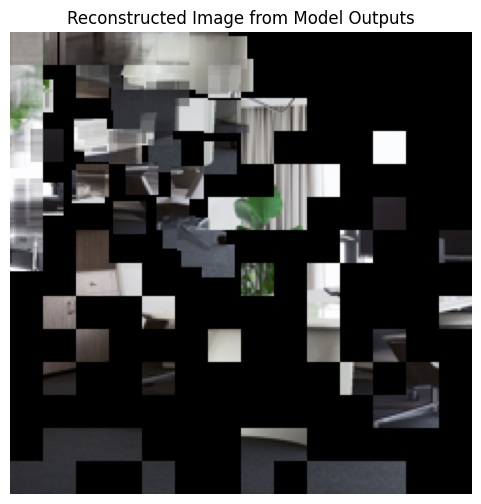

In [35]:
import torch
import matplotlib.pyplot as plt

# --- Step 1: Reconstruct positions for masked patches using predicted pairwise differences ---
def reconstruct_positions_centered_torch(pred_T: torch.Tensor) -> torch.Tensor:
    """
    Given pred_T of shape [N, N, 2] (pairwise differences for masked patches),
    recover absolute positions (up to a global translation) using a centering constraint.
    """
    N = pred_T.shape[0]
    device = pred_T.device
    A_rows = []
    b_rows = []
    
    # Build equations: for each pair (i, j), we want T_j - T_i ≈ pred_T[i, j]
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            eq = torch.zeros((2, N * 2), device=device)
            eq[:, i*2:(i+1)*2] = -torch.eye(2, device=device)
            eq[:, j*2:(j+1)*2] = torch.eye(2, device=device)
            A_rows.append(eq)
            b_rows.append(pred_T[i, j])
    
    A = torch.cat(A_rows, dim=0)  # Shape: [2*N*(N-1), N*2]
    b = torch.stack(b_rows, dim=0).view(-1)  # Shape: [2*N*(N-1)]
    
    # Add centering constraint: sum_i T_i = 0 (two equations)
    constraint = torch.zeros((2, N * 2), device=device)
    for i in range(N):
        constraint[:, i*2:(i+1)*2] = torch.eye(2, device=device)
    A = torch.cat([A, constraint], dim=0)      # Now shape: [2*N*(N-1)+2, N*2]
    b = torch.cat([b, torch.zeros(2, device=device)], dim=0)
    
    # Solve the least-squares system
    solution = torch.linalg.lstsq(A, b).solution
    T = solution.view(N, 2)
    return T

# --- Step 2: Reconstruct the image using model outputs ---
def reconstruct_image_from_model_outputs(model_output: dict, original_image: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    Given the output from PARTMaskedAutoEncoderViT and the original image,
    paste each patch at its predicted position to reconstruct an image.
    
    model_output: dict returned from the forward pass, containing:
       - "patch_positions_vis": [B, N, 2] (sampled patch coordinates from the OffGridPatchEmbed)
       - "ids_keep_pos": [B, N_pos] (indices for patches with position embeddings)
       - "ids_remove_pos": [B, N_nopos] (indices for patches without position embeddings)
       - "pred_T": [B, (N_nopos)**2, 2] (predicted pairwise differences for masked patches)
    original_image: tensor of shape [B, C, H, W]
    patch_size: the patch height/width (assumed square)
    """
    B, C, H, W = original_image.shape
    patch_positions_vis = model_output["patch_positions_vis"]  # [B, N, 2]
    ids_remove_pos = model_output["ids_remove_pos"]            # [B, N_nopos]
    pred_T_flat = model_output["pred_T"]                       # [B, (N_nopos)**2, 2]
    
    N = patch_positions_vis.shape[1]  # total number of patches per image
    N_nopos = ids_remove_pos.shape[1] # number of patches for which the position is predicted
    
    # For each batch element, recover the predicted positions for the masked patches.
    T_pred_list = []
    for b in range(B):
        # Reshape pred_T for batch b to shape [N_nopos, N_nopos, 2]
        pred_T_b = pred_T_flat[b].view(N_nopos, N_nopos, 2)
        # Reconstruct absolute positions for the masked patches:
        T_pred = reconstruct_positions_centered_torch(pred_T_b)  # [N_nopos, 2]
        T_pred_list.append(T_pred)
    T_pred = torch.stack(T_pred_list, dim=0)  # [B, N_nopos, 2]
    
    # --- Step 3: Extract patch images from the original image ---
    # Here we assume that patch_positions_vis contains the top-left coordinates for each patch,
    # so that you can extract a patch by slicing the original image.
    patches = []  # will be a list of tensors of shape [B, N, C, patch_size, patch_size]
    for b in range(B):
        patches_b = []
        for pos in patch_positions_vis[b]:
            y, x = pos
            y = int(y.item())
            x = int(x.item())
            # Ensure the patch lies within image boundaries
            y = max(0, min(H - patch_size, y))
            x = max(0, min(W - patch_size, x))
            patch = original_image[b, :, y:y+patch_size, x:x+patch_size]
            patches_b.append(patch)
        patches.append(torch.stack(patches_b, dim=0))
    patches = torch.stack(patches, dim=0)  # [B, N, C, patch_size, patch_size]
    
    # --- Step 4: Build the full set of patch positions to use for pasting ---
    # For each patch index (0 to N-1), decide whether to use:
    #   - The ground-truth patch_positions_vis (if the patch was kept for position)
    #   - The reconstructed T_pred (if the patch was masked out)
    # ids_remove_pos contains the indices (within 0...N-1) of patches for which the position was removed.
    full_positions = patch_positions_vis.clone()  # start with ground-truth positions
    for b in range(B):
        # Convert ids_remove_pos for batch b to a Python list for easy lookup.
        mask_indices = ids_remove_pos[b].tolist()
        # Replace positions for these indices with the predicted positions.
        for idx, patch_idx in enumerate(mask_indices):
            full_positions[b, patch_idx] = T_pred[b, idx]
    
    # --- Step 5: Paste patches onto a blank canvas using the computed positions ---
    canvas = torch.zeros_like(original_image)  # [B, C, H, W]
    count_map = torch.zeros((B, 1, H, W), device=original_image.device)
    
    for b in range(B):
        for j in range(N):
            pos = full_positions[b, j]
            y, x = pos.round().long().tolist()
            # Ensure the patch will fit in the canvas
            y = max(0, min(H - patch_size, y))
            x = max(0, min(W - patch_size, x))
            patch = patches[b, j]
            canvas[b, :, y:y+patch_size, x:x+patch_size] += patch
            count_map[b, :, y:y+patch_size, x:x+patch_size] += 1
    
    # Avoid division by zero
    count_map[count_map == 0] = 1
    reconstructed = canvas / count_map
    return reconstructed

# --- Example usage ---
# Assume you have:
#   - a trained model,
#   - an input image tensor `img` of shape [B, C, H, W],
#   - and you run:
#       output = model(img)
# Then:
#   reconstructed_img = reconstruct_image_from_model_outputs(output, img, patch_size=16)

# For demonstration, suppose we have a dummy image and dummy model output:
B, C, H, W = 1, 3, 224, 224
patch_size = 16
# Create a dummy image (e.g., a gradient or random image)
# img = torch.linspace(0, 1, steps=H*W).reshape(1, 1, H, W).repeat(1, C, 1, 1)

# Dummy model output structure (normally produced by your forward pass)
# Here we assume N = (224/16)^2 = 196 patches.
# N = (H // patch_size) * (W // patch_size)
# # For simplicity, let patch_positions_vis be a grid of top-left coordinates.
# grid_y = torch.arange(0, H, patch_size)
# grid_x = torch.arange(0, W, patch_size)
# positions = torch.stack(torch.meshgrid(grid_y, grid_x, indexing='ij'), dim=-1).reshape(1, N, 2).float()
# # For the masking simulation, randomly choose half of the indices to be "removed"
# N_nopos = N // 2
# ids = torch.randperm(N)[:N_nopos].unsqueeze(0)
# 
# # Create a dummy pred_T that matches the ground truth differences for the removed patches.
# # Here we simply compute differences from the grid positions.
# positions_removed = torch.gather(positions, dim=1, index=ids.unsqueeze(-1).repeat(1, 1, 2))
# # Compute ground-truth pairwise differences
# diff = positions_removed.unsqueeze(2) - positions_removed.unsqueeze(1)  # [B, N_nopos, N_nopos, 2]
# pred_T_dummy = diff.tanh() * H  # simulate the tanh scaling as in your decoder
# pred_T_dummy = pred_T_dummy.flatten(1,2)  # [B, N_nopos**2, 2]
# 
# # Dummy output dictionary mimicking the model's forward pass
# model_output = {
#     "patch_positions_vis": positions,          # [B, N, 2]
#     "ids_keep_pos": None,  # not used in this reconstruction since we know full ordering
#     "ids_remove_pos": ids, # indices for which we will use predicted positions
#     "pred_T": pred_T_dummy, # predicted pairwise differences for masked patches
# }


# Reconstruct the image from patches and positions:
reconstructed_img = reconstruct_image_from_model_outputs(out, img, patch_size)

# Plot the reconstructed image
plt.figure(figsize=(6,6))
# Permute [C, H, W] to [H, W, C] for display; clamp values to [0,1]
plt.imshow(reconstructed_img.squeeze().permute(1, 2, 0).cpu().clamp(0,1).numpy())
plt.title("Reconstructed Image from Model Outputs")
plt.axis('off')
plt.show()
